In [53]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import uproot as up
import mplhep as hep

# hep.style.use(hep.style.CMS)
plt.style.use(hep.style.ROOT) # ROOT defaults to CMS

In [54]:
## Open the input ROOT file and get the events tree
events = up.open("../nanoaodfiles/ReReco-Run2022G-Muon-PromptNanoAODv10_v1-301949d0-c7ec-4094-9212-dd463bda0538.root:Events")

In [119]:
## Create leaf objects for the branches

l1MuonPts = events["L1Mu_pt"].array(library="ak")
l1MuonEtas = events["L1Mu_eta"].array(library="ak")
l1MuonPhis = events["L1Mu_phi"].array(library="ak")
nL1Muons = events["nL1Mu"].array(library="np")

muonPts = events["Muon_pt"].array(library="ak")
muonEtas = events["Muon_eta"].array(library="ak")
muonPhis = events["Muon_phi"].array(library="ak")
nMuons = events["nMuon"].array(library="np")

In [120]:
nEvents = len(events["event"].array(library="np"))
nEvents

50652

/tmp/ipykernel_349753/560975730.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


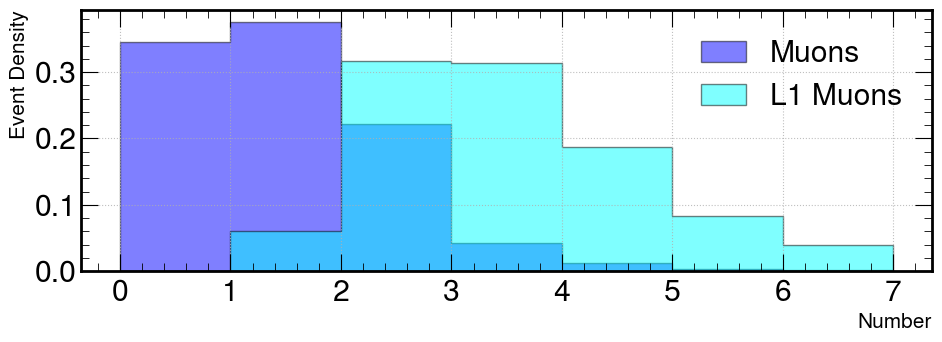

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(
    nMuons, bins=np.arange(8), histtype='stepfilled', facecolor='blue',
    alpha=0.5, edgecolor='black', density=True, label=r'Muons'
)
ax.hist(
    nL1Muons, bins=bins_l1mu, histtype='stepfilled', facecolor='cyan',
    alpha=0.5, edgecolor='black', density=True, label=r'L1 Muons'
)

ax.set_xlabel("Number", fontsize=15)
ax.set_ylabel("Event Density", fontsize=15)
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.show()

In [122]:
l1PtMin = 22
l1EtaMin = 0
l1EtaMax = 2.4

num = []
den = []

dRMin = 0.1
for iEvent in range(nEvents):
    nMuon = nMuons[iEvent]
    nL1Muon = nL1Muons[iEvent]
#     print(nMuon, nL1Muon)
#     print("-------------")
    
    for iMuon in range(nMuon):
        pt = muonPts[iEvent][iMuon]
        eta = muonEtas[iEvent][iMuon]
        phi = muonPhis[iEvent][iMuon]

        # Fill denominator histogram for all muons
        den.append(pt)
        
        muonMatched = False
        iMatched = -999
        for iL1Muon in range(nL1Muon):
            l1pt = l1MuonPts[iEvent][iL1Muon]
            l1eta = l1MuonEtas[iEvent][iL1Muon]
            l1phi = l1MuonPhis[iEvent][iL1Muon]
            
            dPhi = ROOT.TVector2().Phi_mpi_pi(phi - l1phi)
            dEta = eta - l1eta
            dR = np.sqrt(dPhi * dPhi + dEta * dEta)
            
            if (dR < dRMin): 
                muonMatched = True
                iMatched = iL1Muon
                break
            else: 
                continue
        
        if muonMatched:
            matchedl1pt = l1MuonPts[iEvent][iMatched]
            matchedl1eta = l1MuonEtas[iEvent][iMatched]
            matchedl1phi = l1MuonPhis[iEvent][iMatched]
            
            if (abs(matchedl1eta) < l1EtaMax and abs(matchedl1eta) > l1EtaMin and matchedl1pt > l1PtMin):
                # Fill numerator histogram for all muons matched with L1
                num.append(pt)
num = np.array(num)
den = np.array(den)

In [123]:
print(num.shape, den.shape)

(19780,) (51378,)


In [124]:
import itertools

effVsPtBins=list(
    itertools.chain(
        range(0, 30, 1), range(30, 50, 2), 
        range(50, 70, 5), range(70, 100, 10), 
    )
)
effVsPtBins.append(100)
nbins = len(effVsPtBins)-1

/tmp/ipykernel_349753/2676922498.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


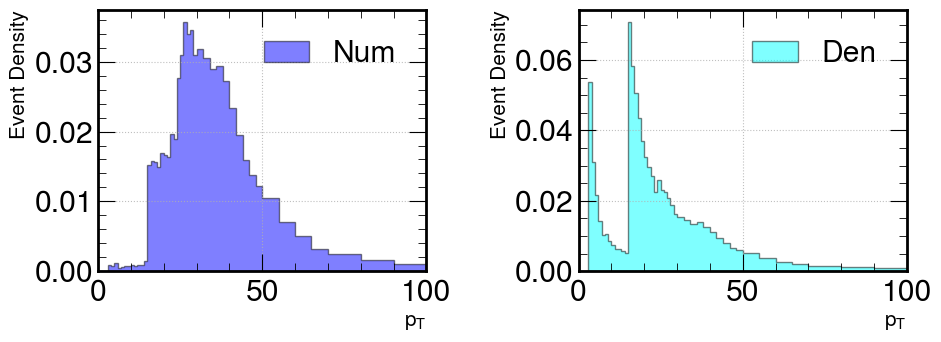

In [125]:
ptmin = 0
ptmax = 100

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(
    num, bins=effVsPtBins, histtype='stepfilled', facecolor='blue',
    alpha=0.5, edgecolor='black', label=r'Num', density=True
)
ax[1].hist(
    den, bins=effVsPtBins, histtype='stepfilled', facecolor='cyan',
    alpha=0.5, edgecolor='black', label=r'Den', density=True
)

ylabel = r'Event Density'
ax[0].set_xlabel(r'$p_{T}$', fontsize=15)
ax[0].set_ylabel(ylabel, fontsize=15)
ax[0].set_xlim(ptmin, ptmax)
ax[0].legend()
ax[0].grid(True)

ax[1].set_xlabel(r'$p_{T}$', fontsize=15)
ax[1].set_ylabel(ylabel, fontsize=15)
ax[1].set_xlim(ptmin, ptmax)
ax[1].legend()
ax[1].grid(True)

fig.tight_layout()
fig.show()

In [126]:
def fillHistFromArray(hist, array):
  [hist.Fill(_) for _ in array]

In [129]:
from array import array

# # Open the output ROOT file
# outFile = ROOT.TFile("output.root", "RECREATE")

# Create a histogram
numHist = ROOT.TH1F("numHist", "", nbins, array('d', effVsPtBins))
denHist = ROOT.TH1F("denHist", "", nbins, array('d', effVsPtBins))

fillHistFromArray(numHist, num)
fillHistFromArray(denHist, den)

Warning in <TFile::Append>: Replacing existing TH1: numHist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denHist (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


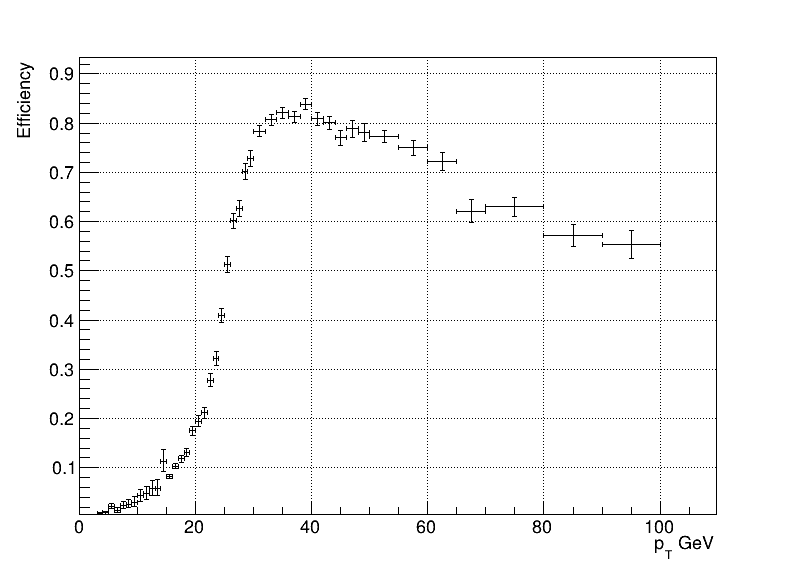

In [133]:
c1 = ROOT.TCanvas("c1", "c1", 800, 600)
pEff = ROOT.TEfficiency(numHist, denHist)
pEff.Draw("AP")
pEff.SetTitle('; p_{T} GeV; Efficiency')
c1.SetGrid()
c1.Draw()